Processing snapshots...
Skipping snapshot 000098: HDF5 file not found
Skipping snapshot 000105: HDF5 file not found
Skipping snapshot 000111: HDF5 file not found
Skipping snapshot 000118: HDF5 file not found
Skipping snapshot 000126: HDF5 file not found
Skipping snapshot 000134: HDF5 file not found
Skipping snapshot 000142: HDF5 file not found
Skipping snapshot 000151: HDF5 file not found
Skipping snapshot 000160: HDF5 file not found
Skipping snapshot 000170: HDF5 file not found
Skipping snapshot 000181: HDF5 file not found
Skipping snapshot 000192: HDF5 file not found
Skipping snapshot 000204: HDF5 file not found
Skipping snapshot 000216: HDF5 file not found
Skipping snapshot 000229: HDF5 file not found
Skipping snapshot 000243: HDF5 file not found
Skipping snapshot 000256: HDF5 file not found
Skipping snapshot 000258: HDF5 file not found
Skipping snapshot 000274: HDF5 file not found
Skipping snapshot 000290: HDF5 file not found
Skipping snapshot 000308: HDF5 file not found
Skipping s

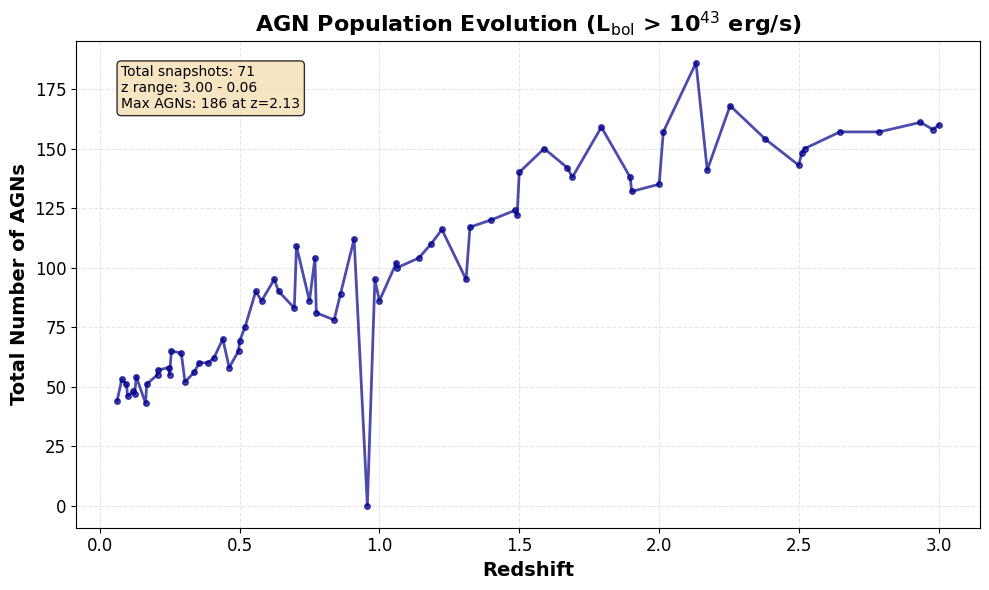

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import pynbody as pnb
import os

# Configuration
hdf5_path_template = "/scratch/stlock/tripleAGNs/halomap_files/HaloBH-TangosPynbodyMap-R25-snap{}.hdf5"
sim_path = "/home/stlock/projects/rrg-babul-ad/SHARED/Romulus/cosmo25/"
output_path = "/scratch/stlock/dualAGNs/plots/total_agn_vs_redshift.png"

# Snapshot list (same as in the pipeline)
snapshots = ['000098','000105','000111','000118','000126','000134','000142','000151','000160','000170','000181',
            '000192','000204','000216','000229','000243','000256','000258','000274','000290','000308',
            '000372','000437','000446',
            '000463','000491','000512','000520','000547','000551','000584','000618','000655',
            '000690','000694','000735','000768','000778','000824','000873','000909','000924','000979','001024',
            '001036','001065','001097','001162','001230','001270','001280',
            '001302','001378','001458','001536','001543','001550','001632','001726','001792','001826','001931','001945',
            '002042','002048','002159','002281','002304','002411','002536','002547','002560','002690','002816','002840',
            '002998','003072','003163','003328','003336','003478','003517','003584','003707','003840','003905','004096',
            '004111','004173','004326','004352','004549','004608','004781','004864','005022','005107','005120','005271',
            '005376','005529','005632','005795','005888','006069','006144','006350','006390','006400','006640','006656',
            '006912','006937','007168','007212','007241','007394','007424','007552','007680','007779','007869','007936',
            '008192']

# AGN threshold (same as in build_dualagn_catalog.py)
Lbol_threshold = 1e43  # erg/s
mdot_threshold = 1.89e-3  # Msun/yr

# Constants for Lbol calculation
msun_to_g = 1.989e33
yr_to_s = 3.154e7
c_cgs = 3e10

# Arrays to store results
redshifts = []
agn_counts = []
snapshot_numbers = []

print("Processing snapshots...")

for i, snap in enumerate(snapshots):
    hdf5_file = hdf5_path_template.format(snap)
    sim_file = os.path.join(sim_path, f"cosmo25p.768sg1bwK1BHe75.{snap}")
    
    # Check if files exist
    if not os.path.exists(hdf5_file):
        print(f"Skipping snapshot {snap}: HDF5 file not found")
        continue
    
    if not os.path.exists(sim_file):
        print(f"Skipping snapshot {snap}: simulation file not found")
        continue
    
    try:
        # Load redshift from simulation
        s = pnb.load(sim_file)
        s.physical_units()
        z = s.properties['z']
        
        # Load BH data from halomap
        with h5py.File(hdf5_file, 'r') as hf:
            bh_mdot = np.array(hf['BH_mdot'])
            bh_mass = np.array(hf['BH_mass'])
        
        # Calculate Lbol for all BHs
        Lbol = 0.1 * bh_mdot * msun_to_g / yr_to_s * c_cgs**2
        
        # Count AGNs: BHs with Lbol > 10^43 erg/s
        agn_mask = Lbol > Lbol_threshold
        n_agn = np.sum(agn_mask)
        
        # Store results
        redshifts.append(z)
        agn_counts.append(n_agn)
        snapshot_numbers.append(snap)
        
        print(f"Snapshot {snap} (z={z:.2f}): {n_agn} AGNs found")
        
    except Exception as e:
        print(f"Error processing snapshot {snap}: {e}")
        continue

# Convert to arrays
redshifts = np.array(redshifts)
agn_counts = np.array(agn_counts)

# Sort by redshift (descending, so time goes left to right)
sort_idx = np.argsort(redshifts)[::-1]
redshifts = redshifts[sort_idx]
agn_counts = agn_counts[sort_idx]

print(f"\nTotal snapshots processed: {len(redshifts)}")
print(f"Redshift range: {redshifts.max():.2f} to {redshifts.min():.2f}")
print(f"AGN count range: {agn_counts.min()} to {agn_counts.max()}")

# Create plot
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(redshifts, agn_counts, marker='o', linestyle='-', linewidth=2, 
        markersize=4, color='darkblue', alpha=0.7)

ax.set_xlabel('Redshift', fontsize=14, fontweight='bold')
ax.set_ylabel('Total Number of AGNs', fontsize=14, fontweight='bold')
ax.set_title(r'AGN Population Evolution (L$_{\rm bol}$ > 10$^{43}$ erg/s)', 
             fontsize=16, fontweight='bold')

ax.grid(True, alpha=0.3, linestyle='--')
ax.tick_params(labelsize=12)

# Add text box with statistics
textstr = f'Total snapshots: {len(redshifts)}\n'
textstr += f'z range: {redshifts.max():.2f} - {redshifts.min():.2f}\n'
textstr += f'Max AGNs: {agn_counts.max()} at z={redshifts[np.argmax(agn_counts)]:.2f}'

props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

plt.tight_layout()

# Save figure
os.makedirs(os.path.dirname(output_path), exist_ok=True)
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"\nPlot saved to: {output_path}")

# Also save data to text file
data_output = output_path.replace('.png', '_data.txt')
with open(data_output, 'w') as f:
    f.write("# Redshift  AGN_Count  Snapshot\n")
    for z, count, snap in zip(redshifts, agn_counts, np.array(snapshot_numbers)[sort_idx]):
        f.write(f"{z:.4f}  {count}  {snap}\n")
print(f"Data saved to: {data_output}")

plt.show()

VALIDATING TRIPLE AGN CATALOG DATA
Found 60 catalog files (pkl format)


REDSHIFT z = 0.21 (1 system(s))

1. COLUMN AVAILABILITY CHECK
----------------------------------------------------------------------
  Primary BH: ✓ All columns present
  Neighbor 1: ✓ All columns present
  Neighbor 2: ✓ All columns present
  >> All expected columns present!

2. DATA VALIDITY CHECK
----------------------------------------------------------------------
  BH_mass: ✓ All valid
  BH_mdot: ✓ All valid
  BH_Lbol: ✓ All valid
  Neighbour1BH_mass: ✓ All valid
  Neighbour1BH_mdot: ✓ All valid
  Neighbour1BH_Lbol: ✓ All valid
  Neighbour2BH_mass: ✓ All valid
  Neighbour2BH_mdot: ✓ All valid
  Neighbour2BH_Lbol: ✓ All valid

3. PHYSICAL CONSTRAINTS CHECK
----------------------------------------------------------------------
  Primary Lbol: ✓ All above 10^43 erg/s
  Neighbor1 Lbol: ✓ All above 10^43 erg/s
  Neighbor2 Lbol: ✓ All above 10^43 erg/s
  Primary Eddington ratio: ✓ All sub-Eddington
  Neighbor1 Eddi

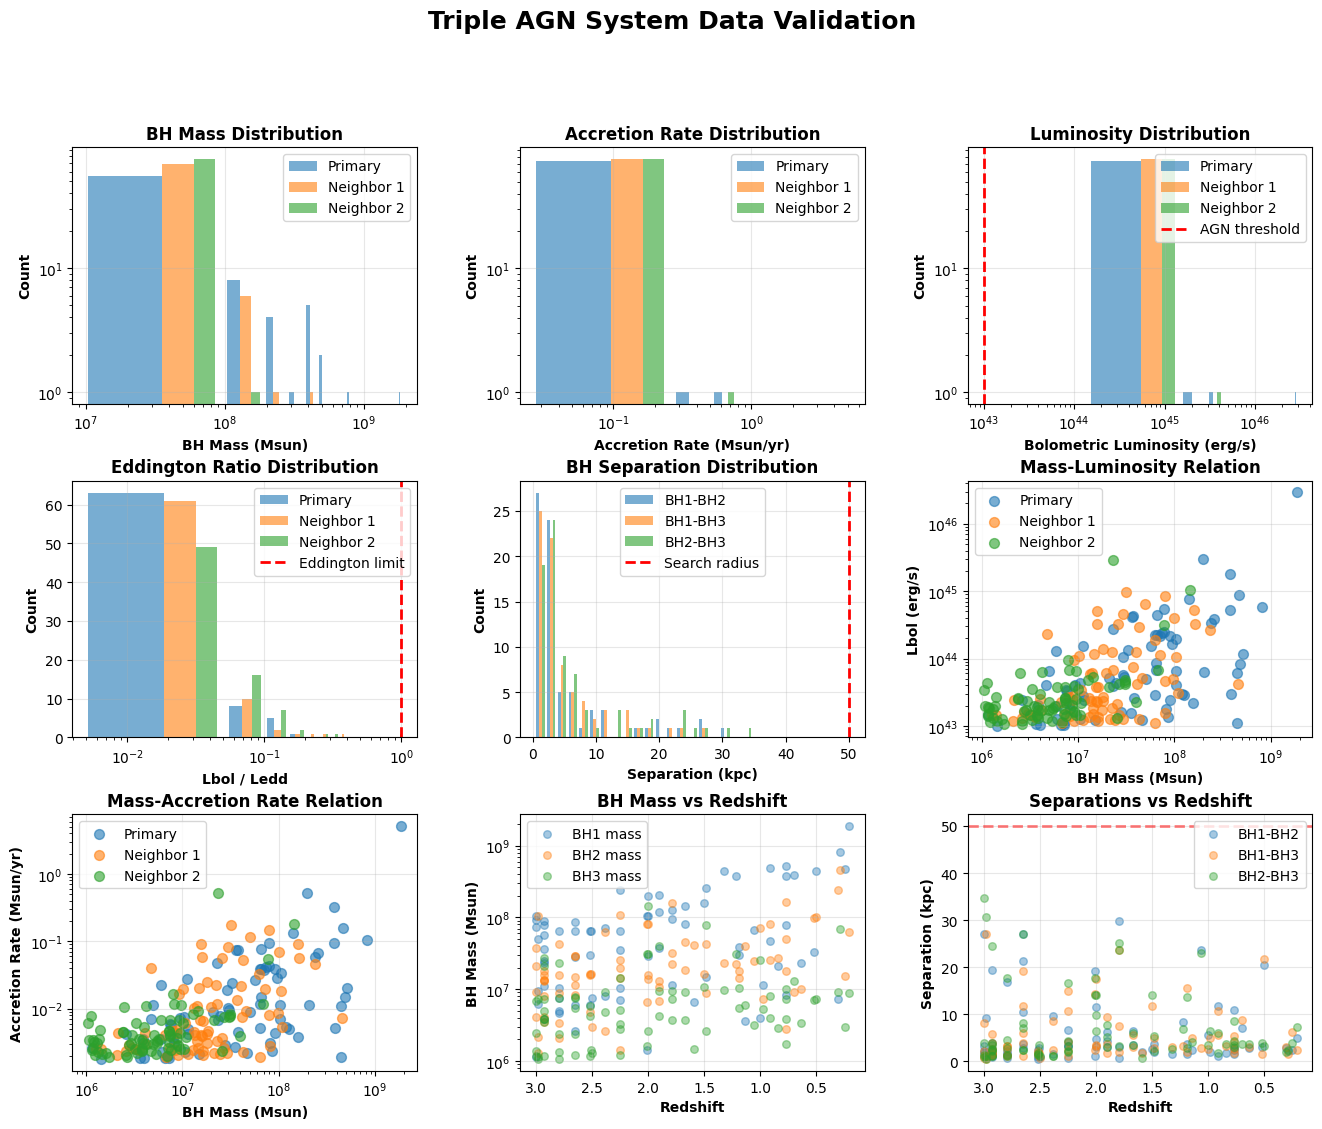

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
from matplotlib.gridspec import GridSpec

# Define paths
catalog_path = "/scratch/stlock/tripleAGNs/catalogs/1e43lum/catalogue_30kpc_1e43lum/"
output_dir = "/scratch/stlock/tripleAGNs/validation/"
os.makedirs(output_dir, exist_ok=True)

print("="*70)
print("VALIDATING TRIPLE AGN CATALOG DATA")
print("="*70)

# Search for catalog files
files_pkl = sorted(glob.glob(f"{catalog_path}TripleAGN-Catalog-R50-z*.pkl"))
files_csv = sorted(glob.glob(f"{catalog_path}TripleAGN-Catalog-R50-z*.csv"))
files_h5 = sorted(glob.glob(f"{catalog_path}TripleAGN-Catalog-R50-z*.h5"))

# Prefer pickle files, then CSV, then HDF5
if files_pkl:
    files_to_read = files_pkl
    file_format = 'pkl'
elif files_csv:
    files_to_read = files_csv
    file_format = 'csv'
elif files_h5:
    files_to_read = files_h5
    file_format = 'h5'
else:
    print("No catalog files found!")
    exit(1)

print(f"Found {len(files_to_read)} catalog files ({file_format} format)\n")

# Storage for all data across redshifts
all_data = []
validation_report = []

# Read each file and validate
for file_path in files_to_read:
    try:
        # Read the file based on format
        if file_format == 'pkl':
            df = pd.read_pickle(file_path)
        elif file_format == 'csv':
            df = pd.read_csv(file_path)
        elif file_format == 'h5':
            df = pd.read_hdf(file_path, key='tripleagn')
        
        if len(df) == 0:
            continue
        
        # Extract redshift from filename
        filename = os.path.basename(file_path)
        z_str = filename.split('-z')[1].split('.')[0] + '.' + filename.split('-z')[1].split('.')[1]
        z = float(z_str)
        
        print(f"\n{'='*70}")
        print(f"REDSHIFT z = {z:.2f} ({len(df)} system(s))")
        print(f"{'='*70}")
        
        file_validation = {
            'redshift': z,
            'num_systems': len(df),
            'issues': []
        }
        
        # Define key columns to check
        bh_columns = {
            'Primary BH': ['BH_id', 'BH_mass', 'BH_mdot', 'BH_Lbol', 'BH_Ledd', 
                          'BH_x', 'BH_y', 'BH_z', 'BH_vx', 'BH_vy', 'BH_vz'],
            'Neighbor 1': ['Neighbour1BH_id', 'Neighbour1BH_mass', 'Neighbour1BH_mdot', 
                          'Neighbour1BH_Lbol', 'Neighbour1BH_Ledd',
                          'Neighbour1BH_x', 'Neighbour1BH_y', 'Neighbour1BH_z'],
            'Neighbor 2': ['Neighbour2BH_id', 'Neighbour2BH_mass', 'Neighbour2BH_mdot', 
                          'Neighbour2BH_Lbol', 'Neighbour2BH_Ledd',
                          'Neighbour2BH_x', 'Neighbour2BH_y', 'Neighbour2BH_z']
        }
        
        # Check column existence
        print("\n1. COLUMN AVAILABILITY CHECK")
        print("-" * 70)
        all_cols_present = True
        for bh_name, cols in bh_columns.items():
            missing = [col for col in cols if col not in df.columns]
            if missing:
                print(f"  {bh_name}: MISSING {len(missing)} columns: {missing}")
                file_validation['issues'].append(f"{bh_name} missing columns: {missing}")
                all_cols_present = False
            else:
                print(f"  {bh_name}: ✓ All columns present")
        
        if all_cols_present:
            print("  >> All expected columns present!")
        
        # Check for NaN/invalid values
        print("\n2. DATA VALIDITY CHECK")
        print("-" * 70)
        
        critical_columns = ['BH_mass', 'BH_mdot', 'BH_Lbol', 
                          'Neighbour1BH_mass', 'Neighbour1BH_mdot', 'Neighbour1BH_Lbol',
                          'Neighbour2BH_mass', 'Neighbour2BH_mdot', 'Neighbour2BH_Lbol']
        
        for col in critical_columns:
            if col in df.columns:
                n_nan = df[col].isna().sum()
                n_inf = np.isinf(df[col]).sum()
                n_zero = (df[col] == 0).sum()
                n_negative = (df[col] < 0).sum()
                
                issues = []
                if n_nan > 0:
                    issues.append(f"{n_nan} NaN")
                if n_inf > 0:
                    issues.append(f"{n_inf} Inf")
                if n_zero > 0:
                    issues.append(f"{n_zero} zeros")
                if n_negative > 0:
                    issues.append(f"{n_negative} negative")
                
                if issues:
                    print(f"  {col}: ⚠ {', '.join(issues)}")
                    file_validation['issues'].append(f"{col}: {', '.join(issues)}")
                else:
                    print(f"  {col}: ✓ All valid")
        
        # Check physical constraints
        print("\n3. PHYSICAL CONSTRAINTS CHECK")
        print("-" * 70)
        
        # AGN luminosity threshold (should all be > 10^43 erg/s)
        lbol_threshold = 1e43
        for bh_label, lbol_col in [('Primary', 'BH_Lbol'), 
                                     ('Neighbor1', 'Neighbour1BH_Lbol'),
                                     ('Neighbor2', 'Neighbour2BH_Lbol')]:
            if lbol_col in df.columns:
                below_threshold = (df[lbol_col] < lbol_threshold).sum()
                if below_threshold > 0:
                    print(f"  {bh_label} Lbol: ⚠ {below_threshold} systems below 10^43 erg/s threshold!")
                    file_validation['issues'].append(f"{bh_label}: {below_threshold} below Lbol threshold")
                else:
                    print(f"  {bh_label} Lbol: ✓ All above 10^43 erg/s")
        
        # Check Eddington ratios
        for bh_label, lbol_col, ledd_col in [('Primary', 'BH_Lbol', 'BH_Ledd'),
                                               ('Neighbor1', 'Neighbour1BH_Lbol', 'Neighbour1BH_Ledd'),
                                               ('Neighbor2', 'Neighbour2BH_Lbol', 'Neighbour2BH_Ledd')]:
            if lbol_col in df.columns and ledd_col in df.columns:
                edd_ratio = df[lbol_col] / df[ledd_col]
                super_edd = (edd_ratio > 1).sum()
                if super_edd > 0:
                    print(f"  {bh_label} Eddington ratio: ⚠ {super_edd} super-Eddington systems")
                    max_ratio = edd_ratio.max()
                    print(f"    Max Lbol/Ledd = {max_ratio:.2f}")
                else:
                    print(f"  {bh_label} Eddington ratio: ✓ All sub-Eddington")
        
        # Check separations
        print("\n4. SEPARATION CONSTRAINTS CHECK")
        print("-" * 70)
        sep_cols = ['Separation_3D_1_kpc', 'Separation_3D_2_kpc', 'Separation_3D_12_kpc']
        for sep_col in sep_cols:
            if sep_col in df.columns:
                min_sep = df[sep_col].min()
                max_sep = df[sep_col].max()
                mean_sep = df[sep_col].mean()
                above_50 = (df[sep_col] > 50).sum()
                
                print(f"  {sep_col}:")
                print(f"    Range: {min_sep:.2f} - {max_sep:.2f} kpc (mean: {mean_sep:.2f})")
                if above_50 > 0:
                    print(f"    ⚠ {above_50} pairs exceed 50 kpc threshold!")
                    file_validation['issues'].append(f"{sep_col}: {above_50} exceed 50 kpc")
        
        # Extract data for all systems at this redshift
        for idx, row in df.iterrows():
            system_data = {
                'redshift': z,
                'system_id': idx,
                
                # Primary BH
                'BH1_mass': row.get('BH_mass', np.nan),
                'BH1_mdot': row.get('BH_mdot', np.nan),
                'BH1_Lbol': row.get('BH_Lbol', np.nan),
                'BH1_Ledd': row.get('BH_Ledd', np.nan),
                'BH1_Lbol_Ledd': row.get('BH_Lbol', np.nan) / row.get('BH_Ledd', 1) if row.get('BH_Ledd', 0) > 0 else np.nan,
                
                # Neighbor 1
                'BH2_mass': row.get('Neighbour1BH_mass', np.nan),
                'BH2_mdot': row.get('Neighbour1BH_mdot', np.nan),
                'BH2_Lbol': row.get('Neighbour1BH_Lbol', np.nan),
                'BH2_Ledd': row.get('Neighbour1BH_Ledd', np.nan),
                'BH2_Lbol_Ledd': row.get('Neighbour1BH_Lbol', np.nan) / row.get('Neighbour1BH_Ledd', 1) if row.get('Neighbour1BH_Ledd', 0) > 0 else np.nan,
                
                # Neighbor 2
                'BH3_mass': row.get('Neighbour2BH_mass', np.nan),
                'BH3_mdot': row.get('Neighbour2BH_mdot', np.nan),
                'BH3_Lbol': row.get('Neighbour2BH_Lbol', np.nan),
                'BH3_Ledd': row.get('Neighbour2BH_Ledd', np.nan),
                'BH3_Lbol_Ledd': row.get('Neighbour2BH_Lbol', np.nan) / row.get('Neighbour2BH_Ledd', 1) if row.get('Neighbour2BH_Ledd', 0) > 0 else np.nan,
                
                # Separations
                'sep_12': row.get('Separation_3D_1_kpc', np.nan),
                'sep_13': row.get('Separation_3D_2_kpc', np.nan),
                'sep_23': row.get('Separation_3D_12_kpc', np.nan),
            }
            all_data.append(system_data)
        
        # Print summary statistics
        print("\n5. SUMMARY STATISTICS")
        print("-" * 70)
        if 'BH_mass' in df.columns:
            print(f"  Primary BH mass range: {df['BH_mass'].min():.2e} - {df['BH_mass'].max():.2e} Msun")
        if 'BH_Lbol' in df.columns:
            print(f"  Primary Lbol range: {df['BH_Lbol'].min():.2e} - {df['BH_Lbol'].max():.2e} erg/s")
        if 'BH_mdot' in df.columns:
            print(f"  Primary mdot range: {df['BH_mdot'].min():.2e} - {df['BH_mdot'].max():.2e} Msun/yr")
        
        validation_report.append(file_validation)
        
    except Exception as e:
        print(f"ERROR reading {os.path.basename(file_path)}: {e}")
        validation_report.append({
            'redshift': 'unknown',
            'num_systems': 0,
            'issues': [f"Failed to read file: {e}"]
        })
        continue

if len(all_data) == 0:
    print("\n\nNo triple AGN systems found in any snapshot!")
    exit(0)

# Convert to DataFrame
data_df = pd.DataFrame(all_data)

# Create comprehensive validation plots
print("\n" + "="*70)
print("CREATING VALIDATION PLOTS")
print("="*70)

fig = plt.figure(figsize=(16, 12))
gs = GridSpec(3, 3, figure=fig, hspace=0.3, wspace=0.3)

# 1. BH Mass distributions
ax1 = fig.add_subplot(gs[0, 0])
ax1.hist([data_df['BH1_mass'].dropna(), data_df['BH2_mass'].dropna(), data_df['BH3_mass'].dropna()],
         bins=20, label=['Primary', 'Neighbor 1', 'Neighbor 2'], alpha=0.6)
ax1.set_xlabel('BH Mass (Msun)', fontweight='bold')
ax1.set_ylabel('Count', fontweight='bold')
ax1.set_title('BH Mass Distribution', fontweight='bold')
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Accretion rate distributions
ax2 = fig.add_subplot(gs[0, 1])
ax2.hist([data_df['BH1_mdot'].dropna(), data_df['BH2_mdot'].dropna(), data_df['BH3_mdot'].dropna()],
         bins=20, label=['Primary', 'Neighbor 1', 'Neighbor 2'], alpha=0.6)
ax2.set_xlabel('Accretion Rate (Msun/yr)', fontweight='bold')
ax2.set_ylabel('Count', fontweight='bold')
ax2.set_title('Accretion Rate Distribution', fontweight='bold')
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Luminosity distributions
ax3 = fig.add_subplot(gs[0, 2])
ax3.hist([data_df['BH1_Lbol'].dropna(), data_df['BH2_Lbol'].dropna(), data_df['BH3_Lbol'].dropna()],
         bins=20, label=['Primary', 'Neighbor 1', 'Neighbor 2'], alpha=0.6)
ax3.axvline(1e43, color='r', linestyle='--', linewidth=2, label='AGN threshold')
ax3.set_xlabel('Bolometric Luminosity (erg/s)', fontweight='bold')
ax3.set_ylabel('Count', fontweight='bold')
ax3.set_title('Luminosity Distribution', fontweight='bold')
ax3.set_yscale('log')
ax3.set_xscale('log')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Eddington ratio distributions
ax4 = fig.add_subplot(gs[1, 0])
ax4.hist([data_df['BH1_Lbol_Ledd'].dropna(), data_df['BH2_Lbol_Ledd'].dropna(), data_df['BH3_Lbol_Ledd'].dropna()],
         bins=20, label=['Primary', 'Neighbor 1', 'Neighbor 2'], alpha=0.6)
ax4.axvline(1.0, color='r', linestyle='--', linewidth=2, label='Eddington limit')
ax4.set_xlabel('Lbol / Ledd', fontweight='bold')
ax4.set_ylabel('Count', fontweight='bold')
ax4.set_title('Eddington Ratio Distribution', fontweight='bold')
ax4.set_xscale('log')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Separation distributions
ax5 = fig.add_subplot(gs[1, 1])
ax5.hist([data_df['sep_12'].dropna(), data_df['sep_13'].dropna(), data_df['sep_23'].dropna()],
         bins=20, label=['BH1-BH2', 'BH1-BH3', 'BH2-BH3'], alpha=0.6)
ax5.axvline(50, color='r', linestyle='--', linewidth=2, label='Search radius')
ax5.set_xlabel('Separation (kpc)', fontweight='bold')
ax5.set_ylabel('Count', fontweight='bold')
ax5.set_title('BH Separation Distribution', fontweight='bold')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. Mass vs Luminosity
ax6 = fig.add_subplot(gs[1, 2])
ax6.scatter(data_df['BH1_mass'], data_df['BH1_Lbol'], alpha=0.6, s=50, label='Primary')
ax6.scatter(data_df['BH2_mass'], data_df['BH2_Lbol'], alpha=0.6, s=50, label='Neighbor 1')
ax6.scatter(data_df['BH3_mass'], data_df['BH3_Lbol'], alpha=0.6, s=50, label='Neighbor 2')
ax6.set_xlabel('BH Mass (Msun)', fontweight='bold')
ax6.set_ylabel('Lbol (erg/s)', fontweight='bold')
ax6.set_title('Mass-Luminosity Relation', fontweight='bold')
ax6.set_xscale('log')
ax6.set_yscale('log')
ax6.legend()
ax6.grid(True, alpha=0.3)

# 7. Mass vs Accretion rate
ax7 = fig.add_subplot(gs[2, 0])
ax7.scatter(data_df['BH1_mass'], data_df['BH1_mdot'], alpha=0.6, s=50, label='Primary')
ax7.scatter(data_df['BH2_mass'], data_df['BH2_mdot'], alpha=0.6, s=50, label='Neighbor 1')
ax7.scatter(data_df['BH3_mass'], data_df['BH3_mdot'], alpha=0.6, s=50, label='Neighbor 2')
ax7.set_xlabel('BH Mass (Msun)', fontweight='bold')
ax7.set_ylabel('Accretion Rate (Msun/yr)', fontweight='bold')
ax7.set_title('Mass-Accretion Rate Relation', fontweight='bold')
ax7.set_xscale('log')
ax7.set_yscale('log')
ax7.legend()
ax7.grid(True, alpha=0.3)

# 8. Properties vs redshift
ax8 = fig.add_subplot(gs[2, 1])
ax8.scatter(data_df['redshift'], data_df['BH1_mass'], alpha=0.4, s=30, label='BH1 mass')
ax8.scatter(data_df['redshift'], data_df['BH2_mass'], alpha=0.4, s=30, label='BH2 mass')
ax8.scatter(data_df['redshift'], data_df['BH3_mass'], alpha=0.4, s=30, label='BH3 mass')
ax8.set_xlabel('Redshift', fontweight='bold')
ax8.set_ylabel('BH Mass (Msun)', fontweight='bold')
ax8.set_title('BH Mass vs Redshift', fontweight='bold')
ax8.set_yscale('log')
ax8.invert_xaxis()
ax8.legend()
ax8.grid(True, alpha=0.3)

# 9. Separation vs redshift
ax9 = fig.add_subplot(gs[2, 2])
ax9.scatter(data_df['redshift'], data_df['sep_12'], alpha=0.4, s=30, label='BH1-BH2')
ax9.scatter(data_df['redshift'], data_df['sep_13'], alpha=0.4, s=30, label='BH1-BH3')
ax9.scatter(data_df['redshift'], data_df['sep_23'], alpha=0.4, s=30, label='BH2-BH3')
ax9.axhline(50, color='r', linestyle='--', linewidth=2, alpha=0.5)
ax9.set_xlabel('Redshift', fontweight='bold')
ax9.set_ylabel('Separation (kpc)', fontweight='bold')
ax9.set_title('Separations vs Redshift', fontweight='bold')
ax9.invert_xaxis()
ax9.legend()
ax9.grid(True, alpha=0.3)

plt.suptitle('Triple AGN System Data Validation', fontsize=18, fontweight='bold', y=0.995)

plot_path = os.path.join(output_dir, "triple_agn_data_validation.png")
#plt.savefig(plot_path, dpi=300, bbox_inches='tight')
print(f"Validation plot saved to: {plot_path}")

# Save data summary
summary_path = os.path.join(output_dir, "data_validation_summary.txt")
with open(summary_path, 'w') as f:
    f.write("TRIPLE AGN DATA VALIDATION SUMMARY\n")
    f.write("="*70 + "\n\n")
    
    f.write(f"Total systems analyzed: {len(data_df)}\n")
    f.write(f"Redshift range: {data_df['redshift'].min():.2f} - {data_df['redshift'].max():.2f}\n\n")
    
    f.write("PRIMARY BH STATISTICS:\n")
    f.write(f"  Mass: {data_df['BH1_mass'].min():.2e} - {data_df['BH1_mass'].max():.2e} Msun (median: {data_df['BH1_mass'].median():.2e})\n")
    f.write(f"  Mdot: {data_df['BH1_mdot'].min():.2e} - {data_df['BH1_mdot'].max():.2e} Msun/yr (median: {data_df['BH1_mdot'].median():.2e})\n")
    f.write(f"  Lbol: {data_df['BH1_Lbol'].min():.2e} - {data_df['BH1_Lbol'].max():.2e} erg/s (median: {data_df['BH1_Lbol'].median():.2e})\n")
    f.write(f"  Lbol/Ledd: {data_df['BH1_Lbol_Ledd'].min():.3f} - {data_df['BH1_Lbol_Ledd'].max():.3f} (median: {data_df['BH1_Lbol_Ledd'].median():.3f})\n\n")
    
    f.write("SEPARATIONS:\n")
    f.write(f"  BH1-BH2: {data_df['sep_12'].min():.2f} - {data_df['sep_12'].max():.2f} kpc (mean: {data_df['sep_12'].mean():.2f})\n")
    f.write(f"  BH1-BH3: {data_df['sep_13'].min():.2f} - {data_df['sep_13'].max():.2f} kpc (mean: {data_df['sep_13'].mean():.2f})\n")
    f.write(f"  BH2-BH3: {data_df['sep_23'].min():.2f} - {data_df['sep_23'].max():.2f} kpc (mean: {data_df['sep_23'].mean():.2f})\n\n")
    
    f.write("DATA QUALITY ISSUES BY REDSHIFT:\n")
    for report in validation_report:
        if report['num_systems'] > 0:
            f.write(f"\nz = {report['redshift']:.2f} ({report['num_systems']} system(s)):\n")
            if report['issues']:
                for issue in report['issues']:
                    f.write(f"  - {issue}\n")
            else:
                f.write("  ✓ No issues detected\n")

print(f"Summary saved to: {summary_path}")

# Save detailed data
#data_path = os.path.join(output_dir, "triple_agn_validated_data.csv")
#data_df.to_csv(data_path, index=False)
#print(f"Detailed data saved to: {data_path}")

print("\n" + "="*70)
print("VALIDATION COMPLETE")
print("="*70)
print(f"Total systems validated: {len(data_df)}")
print(f"Files with issues: {sum(1 for r in validation_report if r['issues'])}")
print(f"All data appears valid: {'YES' if all(not r['issues'] for r in validation_report) else 'NO'}")

COMPARING TRIPLE AGN RUNS WITH DIFFERENT PARAMETERS

READING Lbol > 1e43 erg/s RUNS

Reading catalogs for: 30 kpc
  Path: /scratch/stlock/tripleAGNs/catalogs/1e43lum/catalogue_30kpc_1e43lum/
  Found 60 files (pkl format)
  Successfully read 60 snapshots
  Redshift range: 0.06 - 3.00
  Total triple systems: 77

Reading catalogs for: 50 kpc
  Path: /scratch/stlock/tripleAGNs/catalogs/1e43lum/catalogue_50kpc_1e43lum/
  Found 60 files (pkl format)
  Successfully read 60 snapshots
  Redshift range: 0.06 - 3.00
  Total triple systems: 94

Reading catalogs for: 100 kpc
  Path: /scratch/stlock/tripleAGNs/catalogs/1e43lum/catalogue_100kpc_1e43lum/
  Found 60 files (pkl format)
  Successfully read 60 snapshots
  Redshift range: 0.06 - 3.00
  Total triple systems: 139

READING Lbol > 1e40 erg/s RUNS

Reading catalogs for: 30 kpc
  Path: /scratch/stlock/tripleAGNs/catalogs/1e40lum/catalogue_30kpc_1e40lum/
  Found 60 files (pkl format)
  Successfully read 60 snapshots
  Redshift range: 0.06 - 3.00


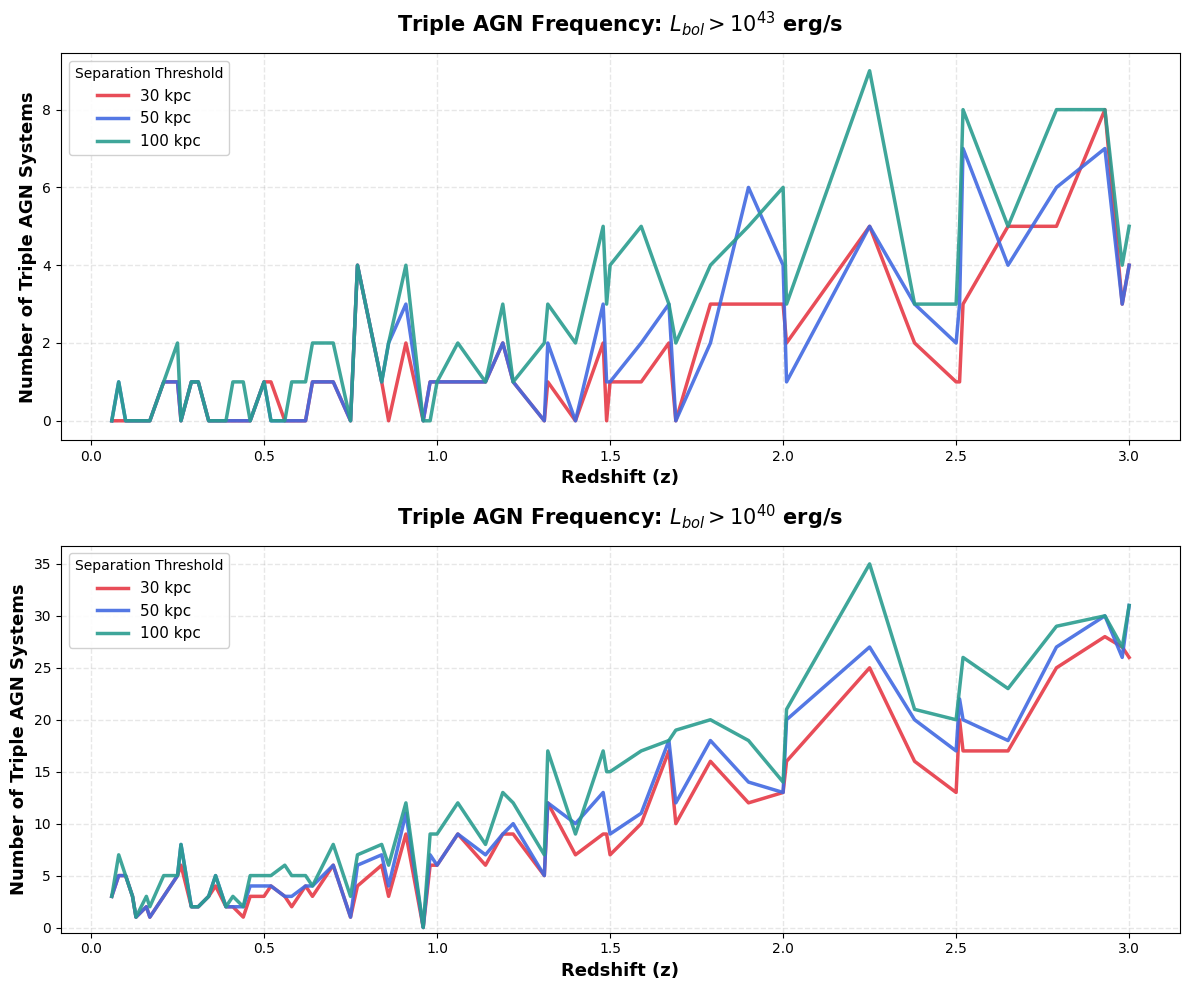

Summary saved to: /scratch/stlock/tripleAGNs/comparison_plots/parameter_comparison_summary.txt

COMPARISON COMPLETE


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os

##############################################
# CONFIGURATION - EDIT THESE PATHS
##############################################

# Dictionary structure: {run_name: catalog_path}
# Runs with Lbol > 1e43 erg/s
runs_1e43 = {
    '30 kpc': "/scratch/stlock/tripleAGNs/catalogs/1e43lum/catalogue_30kpc_1e43lum/",
    '50 kpc': "/scratch/stlock/tripleAGNs/catalogs/1e43lum/catalogue_50kpc_1e43lum/",
    '100 kpc': "/scratch/stlock/tripleAGNs/catalogs/1e43lum/catalogue_100kpc_1e43lum/"
}

# Runs with Lbol > 1e40 erg/s
runs_1e40 = {
    '30 kpc': "/scratch/stlock/tripleAGNs/catalogs/1e40lum/catalogue_30kpc_1e40lum/",
    '50 kpc': "/scratch/stlock/tripleAGNs/catalogs/1e40lum/catalogue_50kpc_1e40lum/",
    '100 kpc': "/scratch/stlock/tripleAGNs/catalogs/1e40lum/catalogue_100kpc_1e40lum/"
}


# Output directory
output_dir = "/scratch/stlock/tripleAGNs/comparison_plots/"
os.makedirs(output_dir, exist_ok=True)

##############################################
# FUNCTIONS
##############################################

def read_catalogs(catalog_path, run_name):
    """Read all catalog files from a given path and return redshifts and counts."""
    
    print(f"\nReading catalogs for: {run_name}")
    print(f"  Path: {catalog_path}")
    
    # Search for files in different formats
    files_pkl = sorted(glob.glob(f"{catalog_path}TripleAGN-Catalog*.pkl"))
    files_csv = sorted(glob.glob(f"{catalog_path}TripleAGN-Catalog*.csv"))
    files_h5 = sorted(glob.glob(f"{catalog_path}TripleAGN-Catalog*.h5"))
    
    # Prefer pickle files, then CSV, then HDF5
    if files_pkl:
        files_to_read = files_pkl
        file_format = 'pkl'
    elif files_csv:
        files_to_read = files_csv
        file_format = 'csv'
    elif files_h5:
        files_to_read = files_h5
        file_format = 'h5'
    else:
        print(f"  WARNING: No catalog files found!")
        return np.array([]), np.array([])
    
    print(f"  Found {len(files_to_read)} files ({file_format} format)")
    
    redshifts = []
    triple_counts = []
    
    # Read each file
    for file_path in files_to_read:
        try:
            # Read the file based on format
            if file_format == 'pkl':
                df = pd.read_pickle(file_path)
            elif file_format == 'csv':
                df = pd.read_csv(file_path)
            elif file_format == 'h5':
                df = pd.read_hdf(file_path, key='tripleagn')
            
            # Extract redshift from filename
            filename = os.path.basename(file_path)
            
            # Handle different filename formats
            if '-z' in filename:
                z_str = filename.split('-z')[1].split('.')[0] + '.' + filename.split('-z')[1].split('.')[1]
            elif '_z' in filename:
                z_str = filename.split('_z')[1].split('.')[0] + '.' + filename.split('_z')[1].split('.')[1]
            else:
                print(f"  WARNING: Cannot parse redshift from {filename}")
                continue
            
            z = float(z_str)
            
            # Count triple systems
            num_triples = len(df)
            
            redshifts.append(z)
            triple_counts.append(num_triples)
            
        except Exception as e:
            print(f"  ERROR reading {os.path.basename(file_path)}: {e}")
            continue
    
    if len(redshifts) == 0:
        print(f"  WARNING: No data successfully read!")
        return np.array([]), np.array([])
    
    # Sort by redshift
    sort_idx = np.argsort(redshifts)
    redshifts = np.array(redshifts)[sort_idx]
    triple_counts = np.array(triple_counts)[sort_idx]
    
    print(f"  Successfully read {len(redshifts)} snapshots")
    print(f"  Redshift range: {redshifts.min():.2f} - {redshifts.max():.2f}")
    print(f"  Total triple systems: {triple_counts.sum()}")
    
    return redshifts, triple_counts

##############################################
# MAIN EXECUTION
##############################################

print("="*70)
print("COMPARING TRIPLE AGN RUNS WITH DIFFERENT PARAMETERS")
print("="*70)

# Read data for all runs
data_1e43 = {}
data_1e40 = {}

print("\n" + "="*70)
print("READING Lbol > 1e43 erg/s RUNS")
print("="*70)

for run_name, catalog_path in runs_1e43.items():
    redshifts, counts = read_catalogs(catalog_path, run_name)
    if len(redshifts) > 0:
        data_1e43[run_name] = {'redshifts': redshifts, 'counts': counts}

print("\n" + "="*70)
print("READING Lbol > 1e40 erg/s RUNS")
print("="*70)

for run_name, catalog_path in runs_1e40.items():
    redshifts, counts = read_catalogs(catalog_path, run_name)
    if len(redshifts) > 0:
        data_1e40[run_name] = {'redshifts': redshifts, 'counts': counts}

# Check if we have data
if len(data_1e43) == 0 and len(data_1e40) == 0:
    print("\nERROR: No data found for any run!")
    exit(1)

##############################################
# PLOTTING
##############################################

print("\n" + "="*70)
print("CREATING COMPARISON PLOTS")
print("="*70)

# Define colors and markers for each separation threshold
colors = {'30 kpc': '#E63946', '50 kpc': '#4169E1', '100 kpc': '#2A9D8F'}
markers = {'30 kpc': 'o', '50 kpc': 's', '100 kpc': '^'}
linestyles = {'30 kpc': '-', '50 kpc': '-', '100 kpc': '-'}

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

##############################################
# PLOT 1: Lbol > 1e43 erg/s
##############################################

if len(data_1e43) > 0:
    for run_name, data in data_1e43.items():
        redshifts = data['redshifts']
        counts = data['counts']
        
        # Plot line only
        ax1.plot(redshifts, counts, 
                linestyle=linestyles.get(run_name, '-'),
                linewidth=2.5, 
                color=colors.get(run_name, 'black'),
                alpha=0.9,
                label=f'{run_name}',
                zorder=2)
    
    ax1.set_xlabel('Redshift (z)', fontsize=13, fontweight='bold')
    ax1.set_ylabel('Number of Triple AGN Systems', fontsize=13, fontweight='bold')
    ax1.set_title('Triple AGN Frequency: $L_{bol} > 10^{43}$ erg/s', 
                  fontsize=15, fontweight='bold', pad=15)
    ax1.grid(True, alpha=0.3, linestyle='--', linewidth=1)
    ax1.legend(fontsize=11, loc='best', framealpha=0.9, title='Separation Threshold')
    ax1.set_ylim(bottom=-0.5)
else:
    ax1.text(0.5, 0.5, 'No data available for Lbol > 1e43 erg/s runs',
            ha='center', va='center', transform=ax1.transAxes, fontsize=14)
    ax1.set_xlabel('Redshift (z)', fontsize=13, fontweight='bold')
    ax1.set_ylabel('Number of Triple AGN Systems', fontsize=13, fontweight='bold')
    ax1.set_title('Triple AGN Frequency: $L_{bol} > 10^{43}$ erg/s', 
                  fontsize=15, fontweight='bold', pad=15)

##############################################
# PLOT 2: Lbol > 1e40 erg/s
##############################################

if len(data_1e40) > 0:
    for run_name, data in data_1e40.items():
        redshifts = data['redshifts']
        counts = data['counts']
        
        # Plot line only
        ax2.plot(redshifts, counts, 
                linestyle=linestyles.get(run_name, '-'),
                linewidth=2.5, 
                color=colors.get(run_name, 'black'),
                alpha=0.9,
                label=f'{run_name}',
                zorder=2)
    
    ax2.set_xlabel('Redshift (z)', fontsize=13, fontweight='bold')
    ax2.set_ylabel('Number of Triple AGN Systems', fontsize=13, fontweight='bold')
    ax2.set_title('Triple AGN Frequency: $L_{bol} > 10^{40}$ erg/s', 
                  fontsize=15, fontweight='bold', pad=15)
    ax2.grid(True, alpha=0.3, linestyle='--', linewidth=1)
    ax2.legend(fontsize=11, loc='best', framealpha=0.9, title='Separation Threshold')
    ax2.set_ylim(bottom=-0.5)
else:
    ax2.text(0.5, 0.5, 'No data available for Lbol > 1e40 erg/s runs',
            ha='center', va='center', transform=ax2.transAxes, fontsize=14)
    ax2.set_xlabel('Redshift (z)', fontsize=13, fontweight='bold')
    ax2.set_ylabel('Number of Triple AGN Systems', fontsize=13, fontweight='bold')
    ax2.set_title('Triple AGN Frequency: $L_{bol} > 10^{40}$ erg/s', 
                  fontsize=15, fontweight='bold', pad=15)

plt.tight_layout()

# Save figure
plot_path = os.path.join(output_dir, "triple_agn_parameter_comparison.png")
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
print(f"\nComparison plot saved to: {plot_path}")

# Also save PDF
pdf_path = plot_path.replace('.png', '.pdf')
plt.savefig(pdf_path, bbox_inches='tight')
print(f"PDF saved to: {pdf_path}")

plt.show()

##############################################
# SAVE SUMMARY STATISTICS
##############################################

summary_path = os.path.join(output_dir, "parameter_comparison_summary.txt")
with open(summary_path, 'w') as f:
    f.write("TRIPLE AGN PARAMETER COMPARISON SUMMARY\n")
    f.write("="*70 + "\n\n")
    
    f.write("Lbol > 1e43 erg/s RUNS:\n")
    f.write("-"*70 + "\n")
    if len(data_1e43) > 0:
        for run_name, data in data_1e43.items():
            f.write(f"\n{run_name}:\n")
            f.write(f"  Total systems: {data['counts'].sum()}\n")
            f.write(f"  Snapshots with systems: {(data['counts'] > 0).sum()}\n")
            f.write(f"  Max systems in one snapshot: {data['counts'].max()}\n")
            if data['counts'].sum() > 0:
                max_idx = np.argmax(data['counts'])
                f.write(f"    (at z = {data['redshifts'][max_idx]:.2f})\n")
            f.write(f"  Detection rate: {100 * (data['counts'] > 0).sum() / len(data['counts']):.1f}%\n")
    else:
        f.write("  No data available\n")
    
    f.write("\n\nLbol > 1e40 erg/s RUNS:\n")
    f.write("-"*70 + "\n")
    if len(data_1e40) > 0:
        for run_name, data in data_1e40.items():
            f.write(f"\n{run_name}:\n")
            f.write(f"  Total systems: {data['counts'].sum()}\n")
            f.write(f"  Snapshots with systems: {(data['counts'] > 0).sum()}\n")
            f.write(f"  Max systems in one snapshot: {data['counts'].max()}\n")
            if data['counts'].sum() > 0:
                max_idx = np.argmax(data['counts'])
                f.write(f"    (at z = {data['redshifts'][max_idx]:.2f})\n")
            f.write(f"  Detection rate: {100 * (data['counts'] > 0).sum() / len(data['counts']):.1f}%\n")
    else:
        f.write("  No data available\n")
    
    # Comparison section
    f.write("\n\nCOMPARISON INSIGHTS:\n")
    f.write("-"*70 + "\n")
    
    if len(data_1e43) > 0:
        total_1e43 = {name: data['counts'].sum() for name, data in data_1e43.items()}
        f.write(f"\nEffect of separation threshold (Lbol > 1e43):\n")
        for name in sorted(total_1e43.keys()):
            f.write(f"  {name}: {total_1e43[name]} systems\n")
    
    if len(data_1e40) > 0:
        total_1e40 = {name: data['counts'].sum() for name, data in data_1e40.items()}
        f.write(f"\nEffect of separation threshold (Lbol > 1e40):\n")
        for name in sorted(total_1e40.keys()):
            f.write(f"  {name}: {total_1e40[name]} systems\n")
    
    if len(data_1e43) > 0 and len(data_1e40) > 0:
        f.write(f"\nEffect of luminosity threshold:\n")
        for name in runs_1e43.keys():
            if name in data_1e43 and name in data_1e40:
                count_1e43 = data_1e43[name]['counts'].sum()
                count_1e40 = data_1e40[name]['counts'].sum()
                ratio = count_1e40 / count_1e43 if count_1e43 > 0 else np.inf
                f.write(f"  {name}: {count_1e40}/{count_1e43} = {ratio:.1f}x more systems with lower threshold\n")

print(f"Summary saved to: {summary_path}")

print("\n" + "="*70)
print("COMPARISON COMPLETE")
print("="*70)